<!-- Assignment 4 - WS 2023 -->

# Adaptive Optimisation (22 points)

This notebook contains the fourth assignment for the exercises in Deep Learning and Neural Nets 1.
It provides a skeleton, i.e. code with gaps, that will be filled out by you in different exercises.
All exercise descriptions are visually annotated by a vertical bar on the left and some extra indentation,
unless you already messed with your jupyter notebook configuration.
Any questions that are not part of the exercise statement do not need to be answered,
but should rather be interpreted as triggers to guide your thought process.

**Note**: The cells in the introductory part (before the first subtitle)
perform all necessary imports and provide utility function that should work without problems.
Please, do not alter this code or add extra import statements in your submission, unless it is explicitly requested!

<span style="color:#d95c4c">**IMPORTANT:**</span> Please, change the name of your submission file so that it contains your student ID!

In this assignment, the goal is to get familiar with some of the most common (adaptive) **optimisation algorithms**. Essentially, the most common optimisation algorithms are nothing more than variants of gradient descent. Although it is often claimed that stochastic gradient descent outperforms any adaptive learning method when carefully configured, it is often more convenient to use a method that requires less tuning.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from nnumpy import Module, Parameter
from nnumpy import LossFunction, Mean
from nnumpy import Optimiser
from nnumpy.data import get_mnist_data
from nnumpy.utils import split_data, to_one_hot

%matplotlib inline

In [2]:
class MeanSquaredErrorLoss(LossFunction):
    """ Module for squared error loss. """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mean = Mean(axis=-1)
    
    def raw_outputs(self, pred, targ):
        diffs, m_cache = self.mean.compute_outputs(pred - targ)
        return diffs ** 2 / 2., (diffs, m_cache)

    def raw_grads(self, grads, cache):
        diffs, m_cache = cache
        dpred = self.mean.compute_grads(grads * diffs, m_cache)
        return dpred, -dpred
    
    
class Scale(Module):
    """ Simple scaling module for testing. """
    
    def __init__(self):
        super().__init__()
        self.register_parameter("scale", np.ones(1))
    
    def compute_outputs(self, x):
        return self.scale * x, x
    
    def compute_grads(self, grads, x):
        self.scale.grad = x.ravel() @ grads.ravel()
        return self.scale * grads

In [3]:
def accuracy(logits, labels):
    """
    Compute accuracy for classification network.
    
    Parameters
    ----------
    logits : ndarray
        The logit-predictions from the network.
    labels : ndarray
        The target labels for the task.
    
    Returns
    -------
    acc : float
        The fraction of correctly classified samples.
    """
    idx = np.argmax(logits, axis=1)
    return np.mean(labels[np.arange(len(idx)), idx])

    
def plot_curves(model, train_errors, valid_errors):
    """
    Plot learning curves
    
    Parameters
    ----------
    model : Module
        The network to plot learning curves for.
    train_errors : ndarray
        The training errors for each batch in every epoch.
    valid_errors : ndarray
        The validation errors after each epoch.
    """
    plt.title("learning curves")
    train_acc, = evaluate(model, accuracy, Dataloader(*train_data))
    loss_curve, = plt.semilogy(np.mean(train_errors, axis=1), 
                           label=f'train (acc: {100 * train_acc:2.2f}%)')
    valid_acc, = evaluate(model, accuracy, Dataloader(*valid_data))
    plt.semilogy(valid_errors, linestyle='--', color=loss_curve.get_color(), 
             label=f'valid (acc: {100 * valid_acc:2.2f}%)')
    plt.legend()
    return plt.gcf()

## Gradient Descent

As you should know by now, the *backpropagation* algorithm is little more than a combination of the chain rule and some form of gradient descent. Although this happens to work well in practice, it is good to be aware of possible issues when using first-order optimisation methods:

 1. Gradient descent can/will get stuck in *local minima*.
 2. The *gradient magnitude* tells you nothing about how far away minima are.
 3. When optimising the *empirical error*, gradient descent would require the gradient over the entire dataset.

Note that this last point is not necessarily an issue, but it is useful to keep in mind. Also, it implies that the gradients that can be computed on the entire dataset do not need to correspond to the gradients that would be required to minimise the generalisation error.

### Exercise 1: Stochasticity (3 Points)

Rather than using plain gradient descent algorithm, a stochastic variant is used to train neural networks. This variant is known as *Stochastic Gradient Descent*, or *SGD* for short. Although this naming scheme seems to suggest that stochasticity is part of the algorithm, it is actually introduced by how we use the data to compute gradients.

Instead of computing the gradients over the entire dataset in one go, the samples in the dataset are split up in more manageable pieces called *mini-batches*. This can speed up the computations significantly and avoids memory problems with very large datasets. Another benefit from mini-batches is that they introduce variation, or *stochasticity*, in the gradient computations. After all, the gradient for each mini-batch will be different to the gradient for other mini-batches or for all samples. This stochasticity can be useful to escape local minima in the optimisation process. To amplify this stochasticity, it is also common to shuffle the samples in the dataset so that mini-batches consist of different samples.

> Complete the `Dataloader` class below to process the data in mini-batches of pre-specified size. Also make sure to shuffle the data to get more stochasticity.

##### Some Notes on python generators

In python, a [generator](https://wiki.python.org/moin/Generators) is a function with some state that can return multiple values. You probably have already used generators without realising it. Probably, the most famous generator is `range`, which could be defined as follows:
```python
def _range(start, stop, step=1):
    i = start
    while i < stop:
        yield i
        i += step
```

Notice the `yield` keyword. This has a similar effect as `return` in that it provides a value to the outer scope of the function. However, it does not cause the function to be exited. Instead, the current state in the function is stored until the next value is requested. To get the return values of a generator, there are essentially two options:
 1. Using the `next` function. This will simply run the function until the next `yield` statement and give back the yielded value.
 2. By iterating over the generator in any way. This will consequently call `next` on the generator until the function exits.
 
For more information, please refer to the internet.

In [68]:
class Dataloader:
    
    def __init__(self, x, y, batch_size=None, shuffle=False, seed=None):
        """
        Parameters
        ----------
        x : (N, ...) ndarray
            the `N` input samples in the dataset
        y : (N, ...) ndarray
            the `N` output samples in the dataset
        batch_size : int, optional
            number of samples to include in a single mini-batch.
        shuffle : bool, optional
            whether or not the data should be shuffled.
        seed : int, optional
            seed for the pseudo random number generator used for shuffling.
        """
        self.x = x
        self.y = y
        self.batch_size = len(x) if batch_size is None else int(batch_size)
        self.shuffle = shuffle
        self.rng = np.random.default_rng(seed)
    
    def __iter__(self):
        """
        Iterates over the samples of the data.
        
        Yields
        ------
        x : ndarray
            input features for the batch
        y : ndarray
            target values for the batch
            
        Notes
        -----
        Each batch should contain the specified number of samples,
        except for the last batch if the batch_size does 
        not divide the number of samples in the data.
        """
        x, y = np.copy(self.x), np.copy(self.y)
        # YOUR CODE HERE
        #raise NotImplementedError()
        

        if self.shuffle:
            shuffled_indices = self.rng.permutation(len(self.x))
            self.x  = self.x[shuffled_indices] 
            self.y  = self.y[shuffled_indices]

        # Generating batches from the dataset
        for idx in range(0, len(self.x), self.batch_size):
            batch_end = idx + self.batch_size
            if batch_end > len(self.x):
                batch_end = len(self.x)
            batch_x = self.x[idx:batch_end]
            batch_y = self.y[idx:batch_end]
            yield batch_x, batch_y


 
            
    def __len__(self):
        return -(-len(self.x) // self.batch_size)

In [69]:
# Test Cell: do not edit or delete! 
data = np.arange(7)
data_loader = Dataloader(data, np.copy(data), batch_size=3, shuffle=False)
xy = next(iter(data_loader))
assert isinstance(xy, tuple), (
    "ex1: the dataloader does not yield tuples (-0.5 points)"
)
assert len(xy) == 2, (
    "ex1: the dataloader does not yield inputs and outputs (-0.5 points)"
)

x_batch, y_batch = xy
assert isinstance(x_batch, np.ndarray), (
    "ex1: the input batch yielded by the dataloader is not a numpy array (-0.5 points)"
)
assert isinstance(y_batch, np.ndarray), (
    "ex1: the label batch yielded by the dataloader is not a numpy array (-0.5 points)"
)

In [70]:
# Test Cell: do not edit or delete!
data = np.arange(7)
data_loader = Dataloader(data, np.copy(data), batch_size=3, shuffle=False)
x_batch, y_batch = next(iter(data_loader))
assert len(x_batch) == 3, (
    "ex1: number of samples in input batch is not correct (-0.5 points)"
)
assert len(y_batch) == 3, (
    "ex1: number of samples in label batch is not correct (-0.5 points)"
)

In [67]:
# Test Cell: do not edit or delete! 
data = np.arange(7)
data_loader = Dataloader(data, np.copy(data), batch_size=3, shuffle=True, seed=17)
x_batch, y_batch = next(iter(data_loader))
assert isinstance(x_batch, np.ndarray), (
    "ex1: the shuffled input batch yielded by the dataloader is not a numpy array (-1 point)"
)
assert isinstance(y_batch, np.ndarray), (
    "ex1: the shuffled label batch yielded by the dataloader is not a numpy array (-1 point)"
)
assert len(x_batch) == 3, (
    "ex1: number of samples in shuffled input batch is not correct (-1 point)"
)
assert len(y_batch) == 3, (
    "ex1: number of samples in shuffled label batch is not correct (-1 point)"
)

In [ ]:
# Test Cell: do not edit or delete!

### Exercise 2: Gradient Descent with Momentum (3 Points)

Another way to keep gradient descent from getting stuck in local minima is to use momentum. Momentum accumulates the gradient directions over different batches and accelerates/decelarates the descent when all gradients point in the same/different direction(s). This also means that the update does not directly use the magnitude of the gradient, but instead focuses on the direction. 

> Implement the `get_direction` and `init_state` methods for the gradient descent optimiser with momentum.

In [105]:
class GradientDescent(Optimiser):
    """ NNumpy implementation of gradient descent. """

    def __init__(self, parameters, lr: float, momentum: float = 0.):
        """
        Parameters
        ----------
        momentum : float
            Momentum term for the gradient descent.
        """
        self.mu = momentum
        super().__init__(parameters, lr)

    def init_state(self, par):
        """
        Create the initial optimiser state for a parameter.

        Parameters
        ----------
        par : Parameter
            The parameter to create the initial state for.

        Returns
        -------
        state : object or tuple of objects
            The initial optimiser state for the given parameter.
        """
        # YOUR CODE HERE
        #raise NotImplementedError()
        state = np.zeros_like(par)
        return state
        
        
        
        
    def get_direction(self, grad, state):
        """
        Compute the update direction from gradient and state for single parameter.

        Parameters
        ----------
        grad : ndarray
            Gradient for the parameter to update.
        state : object or tuple of objects
            State information that is necessary to compute the update direction.

        Returns
        -------
        direction : ndarray
            The update direction according to the algorithm.
        new_state: object or tuple of objects
            Updated state information after computing the update direction.
        """
        # YOUR CODE HERE
        #raise NotImplementedError()


        momentum_term = self.mu * state
        adjusted_gradient = (1 - self.mu) * grad
        new_state = momentum_term - adjusted_gradient
        direction = - new_state

        return  direction, new_state
    
    
    

In [106]:
# Test Cell: do not edit or delete!
par = Parameter(np.zeros(10))
gd = GradientDescent([par], lr=1e-2)
state0 = gd.init_state(par)
out = gd.get_direction(np.zeros_like(par), state0)
assert isinstance(out, tuple) and len(out) == 2, (
    "ex2: get_direction does not return tuple with direction and new_state (-1 point)"
)
direction, new_state = out
assert isinstance(direction, np.ndarray), (
    "ex2: get_direction does not return direction as numpy array (-1 point)"
)
assert type(state0) == type(new_state), (
    "ex2: get_direction returns inconsistent state object (-1 point)"
)

In [107]:
# Test Cell: do not edit or delete!
par = Parameter(np.zeros(10))
gd = GradientDescent([par], lr=1e-2, momentum=0.9)
state0 = gd.init_state(par)

In [108]:
# Test Cell: do not edit or delete!
par = Parameter(np.zeros(10))
gd = GradientDescent([par], lr=1e-2, momentum=0.9)
state0 = gd.init_state(par)
direction, new_state = gd.get_direction(np.zeros_like(par), state0)
assert isinstance(direction, np.ndarray), (
    "ex2: get_direction with momentum does not return direction as numpy array (-1 point)"
)
assert type(state0) == type(new_state), (
    "ex2: get_direction with momentum returns inconsistent state object (-1 point)"
)

### Exercise 3: The Adamax Optimiser (5 Points)

Momentum already provides a way to reduce the importance of the gradient magnitude. 
With adaptive learning rate methods, an attempt is made to ignore most of the magnitude information and the size of the update is mainly controlled by controlling the learning rate. 
One of the most popular first order adaptive methods in practice, is the Adam optimiser.
However, Adam also has a sibling called *Adamax* that typically performs on a similar level.

To understand Adamax, we have to look at the variance as a rescaled $L_2$ norm.
Instead of dividing by the $L_2$ norm, as it is done in Adam, Adamax divides by the $L_\inf$ norm.
This gives rise to the following updates for first and second moment estimates:

$$\begin{aligned}
    \boldsymbol{m}^{(t)} &= \beta_1 \boldsymbol{m}^{(t-1)} + (1 - \beta_1) \boldsymbol{g}^{(t)} \\
    \boldsymbol{u}^{(t)} &= \max\Bigl(\beta_2 \boldsymbol{u}^{(t-1)}, \bigl|\boldsymbol{g}^{(t)}\bigr|\Bigr),
\end{aligned}$$

giving rise to the update:

$$\boldsymbol{w}^{(t+1)} = \boldsymbol{w}^{(t)} - \eta \frac{1}{\boldsymbol{u}^{(t)} + \epsilon} \odot \boldsymbol{m}^{(t)}.$$

> Implement the `get_direction` and `init_state` methods for the Adamax optimisation algorithm.
> Also, make sure to implement a bias correction for the exponential moving averages.

In [253]:
class Adamax(Optimiser):
    """ NNumpy implementation of the Adam algorithm. """

    def __init__(self, parameters, lr: float = 1e-3, betas: tuple = (.9, .999),
                 epsilon: float = 1e-7, bias_correction=True):
        """
        Parameters
        ----------
        betas : tuple of 2 floats, optional
            Decay factors for the exponential averaging of mean, resp. variance.
        epsilon : float, optional
            Small number that is added to denominator for numerical stability.
        bias_correction : bool, optional
            Whether or not mean and bias estimates should be bias-corrected.
        """
        beta1, beta2 = betas
        self.beta1 = float(beta1)
        self.beta2 = float(beta2)
        self.eps = float(epsilon)
        self.bias_correction = bias_correction
        super().__init__(parameters, lr)

    def init_state(self, par):
        """
        Create the initial optimiser state for a parameter.

        Parameters
        ----------
        par : Parameter
            The parameter to create the initial state for.

        Returns
        -------
        state : object or tuple of objects
            The initial optimiser state for the given parameter.
        """
        # YOUR CODE HERE
        #raise NotImplementedError()
        
        
        m = np.zeros_like(par)  
        v = np.zeros_like(par)  
        return (m, v , 1)

    def get_direction(self, grad, state):
        """
        Compute the update direction from gradient and state for single parameter.

        Parameters
        ----------
        grad : ndarray
            Gradient for the parameter to update.
        state : object or tuple of objects
            State information that is necessary to compute the update direction.

        Returns
        -------
        direction : ndarray
            The update direction according to the algorithm.
        new_state: object or tuple of objects
            Updated state information after computing the update direction.
        """
        # YOUR CODE HERE
        #raise NotImplementedError()
        

        m, v, t = state
        m_updated = self.beta1 * m + (1 - self.beta1) * grad
        v_updated = np.maximum(self.beta2 * v, np.abs(grad))

        # Adjust for bias if necessary
        if self.bias_correction:
             corrected_m = m_updated / (1 - self.beta1 ** t)
             corrected_v = v_updated / (1 - self.beta2 ** t)

        # Calculate the update direction
        direction = corrected_m / (corrected_v + self.eps)

        # Prepare the new state
        new_state = (m_updated, v_updated, t + 1)

        return direction, new_state
    
    
   


In [254]:
# Test Cell: do not edit or delete!
par = Parameter(np.zeros(10))
adamax = Adamax([par])
state0 = adamax.init_state(par)

In [255]:
# Test Cell: do not edit or delete!
par = Parameter(np.zeros(10))
adamax = Adamax([par])
state0 = adamax.init_state(par)
out = adamax.get_direction(np.zeros_like(par), state0)
assert isinstance(out, tuple) and len(out) == 2, (
    "ex3: get_direction does not return tuple with direction and new_state (-1 point)"
)
direction, new_state = out
assert isinstance(direction, np.ndarray), (
    "ex3: get_direction does not return direction as numpy array (-1 point)"
)
assert type(state0) == type(new_state), (
    "ex3: get_direction returns inconsistent state object (-1 point)"
)

In [256]:
# Test Cell: do not edit or delete!
par = Parameter(np.zeros(10))
adamax = Adamax([par])
state0 = adamax.init_state(par)
grad = np.ones_like(par)
dir1, state1 = adamax.get_direction(grad, state0)
dir2, state2 = adamax.get_direction(grad, state1)
dir3, _ = adamax.get_direction(grad, state2)
assert np.allclose(dir3, grad), (
    "ex3: get_direction returns wrong direction for third update when gradients are one (-1 point)"
)

AssertionError: ex3: get_direction returns wrong direction for third update when gradients are one (-1 point)

In [ ]:
# Test Cell: do not edit or delete!

In [ ]:
# Test Cell: do not edit or delete!

## Training Networks

At this point, you should have all components that are necessary to start training neural networks.
With the modules you created throughout this semester, you can already build a wide variety of network architectures.
Together with the optimisers from this assignment, you can start training networks in your very own DL framework!

In [197]:
# import the modules you have written in previous assignments,
# or alternatively, the code for these modules, in this box.
# e.g. from nnumpy import Sequential, Linear, Conv2d, MaxPool2d, Tanh, LogitCrossEntropy

# YOUR CODE HERE
#raise NotImplementedError()


class Sequential(Container):
    """
    NNumpy module that chains together multiple one-to-one sub-modules.
    
    Examples
    --------
    Doubling a module could be done as follows:
    >>> module = Module()
    >>> seq = Sequential(module, module)
    
    Modules can be accessed by index or by iteration:
    >>> assert module is seq[0] and module is seq[1]
    >>> mod1, mod2 = (m for m in seq)
    >>> assert mod1 is module and mod2 is module
    """

    def __init__(self, *modules):
        super().__init__()
        if len(modules) == 1 and hasattr(modules[0], '__iter__'):
            modules = modules[0]
        
        for mod in modules:
            self.add_module(mod)

    def compute_outputs(self, x):
        """
        Parameters
        ----------
        x : (N, D) ndarray

        Returns
        -------
        y : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        # YOUR CODE HERE
        cache = []
        s = x
        
        for m in self._modules:
           
            y, c = m.compute_outputs(s)
            cache.append(c)
            s = y
        return y, cache

    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        dx : (N, D) ndarray
        """
        # YOUR CODE HERE
        for n,m in enumerate(self._modules[::-1]):
            x = cache[len(cache)-1-n]
            
            ds = m.compute_grads(grads, x)
            grads = ds
        return ds


########################################################################################

class Linear(Module):
    """
    NNumpy implementation of a fully connected layer.

    Attributes
    ----------
    in_features : int
        Number of input features (D) this layer expects.
    out_features : int
        Number of output features (K) this layer expects.
    use_bias : bool
        Flag to indicate whether the bias parameters are used.

    w : Parameter
        Weight matrix.
    b : Parameter
        Bias vector.

    Examples
    --------
    >>> fc = Linear(10, 1)
    >>> fc.reset_parameters()  # init parameters
    >>> s = fc.forward(np.random.randn(1, 10))
    >>> fc.zero_grad()  # init parameter gradients
    >>> ds = fc.backward(np.ones_like(s))
    """
    
    def __init__(self, in_features, out_features, use_bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        
        # register parameters 'w' and 'b' here (mind use_bias!)
        # raise NotImplementedError("TODO: register parameters in Linear.__init__!")
        
        self.register_parameter('w', np.empty((out_features, in_features)))
        if self.use_bias:    
            self.register_parameter('b', np.empty((1,out_features)))
        # self.register_parameter('use_bias', [use_bias])
        
        self.reset_parameters()
        
    def reset_parameters(self, seed: int = None):
        """ 
        Reset the parameters to some random values.
        
        Parameters
        ----------
        seed : int, optional
            Seed for random initialisation.
        """
        rng = np.random.default_rng(seed)
        self.w = rng.standard_normal(size=self.w.shape)
        if self.use_bias:
            self.b = np.zeros_like(self.b)
    
    def compute_outputs(self, x):
        """
        Parameters
        ----------
        x : (N, D) ndarray

        Returns
        -------
        s : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        #raise NotImplementedError("TODO: implement Linear.compute_outputs method!")
        

        if len(x.shape) == 1:
            x = x.reshape(1, x.shape[0])
        s = x.dot(self.w.T)
        if self.use_bias:
            s+= self.b
        cache = x
        
        return s, cache
    
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        dx : (N, D) ndarray
        """
        # raise NotImplementedError("TODO: implement Linear.compute_grads method!")
        x = cache
        
        
        dw = grads.T.dot(x)
        dx = grads.dot(self.w)
        
        self.w.grad = dw
        if self.use_bias:
            db = grads.sum(axis=0, keepdims=True)
            self.b.grad = db
        return dx





#################################################################################

class Tanh(Module):
    """ NNumpy implementation of the hyperbolic tangent function. """
        
    def compute_outputs(self, s):
        """
        Parameters
        ----------
        s : (N, K) ndarray
        
        Returns
        -------
        a : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        # raise NotImplementedError("TODO: implement Tanh.compute_outputs method!")
        self.zero_grad()
        a = np.tanh(s)
        cache = s
        
        return a, cache
    
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        ds : (N, K) ndarray
        """
        # raise NotImplementedError("TODO: implement Tanh.compute_grads method!")
        self.zero_grad()
        s = cache
        dtanh = 1 - (np.tanh(s)** 2)
        ds =  grads * dtanh
        
        return ds



####################################################################################

class LogitCrossEntropy(LossFunction):
    """
    NNumpy implementation of the cross entropy loss function
    computed from the logits, i.e. before applying the softmax nonlinearity.
    """

    def raw_outputs(self, logits, targets):
        """
        Computation of loss without reduction.

        Parameters
        ----------
        logits : (N, K) ndarray
        targets : (N, K) ndarray
        
        Returns
        -------
        cross_entropy : (N, 1) ndarray
        cache : ndarray or iterable of ndarrays
        """
        eps = 1e-15
        # Normalize the logits
        logits = logits - logits.max(axis=-1, keepdims=True)
        # Apply the softmax function to the logits
        probs = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        probs = np.clip(probs, eps, 1 - eps)

        y_pred = probs
        # print(f"y_pred: {y_pred}")
        
        l_ce = -(targets * np.log(y_pred)).sum()

        cache = y_pred, targets
        return l_ce, cache
        

    def raw_grads(self, grads, cache):
        """
        Computation of gradients for loss without reduction.

        Parameters
        ----------
        grads : (N, 1) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        dlogits : (N, K) ndarray
        dtargets : (N, K) ndarray
        """
        softmax, targets = cache
        
        dlogits = grads * (softmax - targets)
        dtargets = grads * -np.log(softmax)

        return dlogits, dtargets


#####################################################################################################

class Conv2d(Module):
    """ Numpy DL implementation of a 2D convolutional layer. """
    
    def __init__(self, in_channels, out_channels, kernel_size, use_bias=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.use_bias = use_bias
        
        # create parameters 'w' and 'b'
        # YOUR CODE HERE
        #raise NotImplementedError()
        
        self.register_parameter('w', np.empty((out_channels, in_channels, *kernel_size)))

        if use_bias:
            self.register_parameter('b', np.empty(out_channels))

        self.reset_parameters()
        
        
    def reset_parameters(self, seed: int = None):
        """ 
        Reset the parameters to some random values.
        
        Parameters
        ----------
        seed : int, optional
            Seed for random initialisation.
        """
        rng = np.random.default_rng(seed)
        self.w = rng.standard_normal(size=self.w.shape)
        if self.use_bias:
            self.b = np.zeros_like(self.b)
        
    def compute_outputs(self, x):
        """
        Parameters
        ----------
        x : (N, Ci, H, W) ndarray
        
        Returns
        -------
        feature_maps : (N, Co, H', W') ndarray
        cache : ndarray or tuple of ndarrays
        """
        # YOUR CODE HERE
        #raise NotImplementedError()
        
        out = multi_channel_convolution2d(x, self.w)

        if self.use_bias:
            out += self.b[np.newaxis, :, np.newaxis, np.newaxis]

        return out, x
    
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, Co, H', W') ndarray
        cache : ndarray or tuple of ndarrays
        
        Returns
        -------
        dx : (N, Ci, H, W) ndarray
        """
        # YOUR CODE HERE
        #raise NotImplementedError()
        x = cache
        R1, R2 = self.kernel_size

        self.w.grad = np.moveaxis(
            multi_channel_convolution2d(
                np.moveaxis(x, 1, 0),
                np.moveaxis(grads, 1, 0)
            ),
            # revert to keep same dimensions as x and grads had before
            1, 0
        )

        if self.use_bias:
            self.b.grad = np.sum(grads, axis=(0, 2, 3))

        return multi_channel_convolution2d(
            # pad grads with zeroes as dimensions get reduced
            np.pad(grads, ((0,), (0,), (R1 - 1,), (R2 - 1,))),
            # switch axis to match dimensions
            np.moveaxis(
                # flip values on the last two axis
                np.flip(self.w, (2, 3)),
                1, 0
            )
        )


###################################################################################

class MaxPool2d(Module):
    """ Numpy DL implementation of a max-pooling layer. """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = tuple(kernel_size)

    def compute_outputs(self, x):
        """
        Parameters
        ----------
        x : (N, C, H, W) ndarray

        Returns
        -------
        a : (N, C, H', W') ndarray
        cache : ndarray or tuple of ndarrays
        """
        # YOUR CODE HERE
        #raise NotImplementedError()
              
        cache =  x
        N, C, H, W = x.shape
        H_a = int(H/self.kernel_size[0])
        W_a = int(W/self.kernel_size[1]) 
        
        x_column = sig2col(x, self.kernel_size, stride = self.kernel_size).reshape (N, C, H_a, W_a, -1 )
        k_column = np.ones(self.kernel_size).reshape(-1)
        avg = (self.kernel_size[0] * self.kernel_size [1])
        
        a = (x_column @ k_column.T) * 1/avg

        return a, cache
    

    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, C, H', W') ndarray
        cache : ndarray or tuple of ndarrays

        Returns
        -------
        dx : (N, C, H, W) ndarray
        """
        # YOUR CODE HERE
        #raise NotImplementedError()
        
        self.zero_grad()
        x = cache
        N ,C ,H , W = x.shape
        avg = self.kernel_size[0] * self.kernel_size[1]
        
        grads_ = grads.reshape(N, C, -1)
        dx = np.repeat(grads_, avg ,axis= -1) * (1/avg)
        dx = dx.reshape(N,C,H,W)
        
        return dx

In [198]:
class Flatten(Module):
    """ NNumpy module to convert multi-dimensional outputs to a single vector. """
    
    def compute_outputs(self, x):
        return x.reshape(len(x), -1), x.shape
    
    def compute_grads(self, grads, shape):
        return grads.reshape(shape)

The goal of the remainder of this assignment will be to train a network on the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

In [199]:
def process_data(x_train, y_train):
    x_train = x_train.reshape(-1, 1, 28, 28)
    y_train = to_one_hot(y_train)
    
    # NOTE: custom data processing is allowed
    x_train = np.pad(x_train, ((0, 0), (0, 0), (2, 2), (2, 2)))
    x_train = x_train - np.mean(x_train, axis=(1, 2, 3), keepdims=True)
    x_train = x_train / np.std(x_train, axis=(1, 2, 3), keepdims=True)
    
    return x_train, y_train

x_train, y_train = get_mnist_data()
x_train, y_train = process_data(x_train, y_train)
print(x_train.shape, y_train.shape)

(60000, 1, 32, 32) (60000, 10)


### Exercise 4: Evaluation and Update (3 Points)

When using the optimisers to fit a neural network to a given set of data, we can effectively minimise the empirical error. However, we are actually interested in minimising the risk. Therefore, it is also useful to evaluate the network regularly on unseen data.

 > Implement the `evaluate`, and `update` functions so that they perform the training and evaluation computations, respectively, for one iteration (aka *epoch*) over the entire dataset. Make sure to return the loss values to get loss curves at the end of this assignment.
 
**Hint:** you can use the `step` method of the optimiser to update the parameters.

In [200]:
def evaluate(network, metric, data_loader):
    """
    Evaluate a network by computing a metric for specific data.
    
    Parameters
    ----------
    network : Module
        A module that implements the network.
    metric : callable
        A function that takes logits and labels 
        and returns a scalar numpy array.
    data_loader : Dataloader
        The data loader that provides the batches.
        
    Returns
    -------
    values : ndarray
        The computed metric values for each batch in the data loader.
    """
    network.eval()
    
    # YOUR CODE HERE
    #raise NotImplementedError()

    # Initialize an empty list to store evaluation results
    eval_results = []

    
    for x, y in tqdm(data_loader, desc=f'Evaluating {global_epoch}'):

        # Reset gradients in the network
        network.zero_grad()

        # Generate predictions for the current batch
        predictions = network(x)

        # Compute the evaluation metric for the current batch
        eval_metric_value = metric(predictions, y)

        
        eval_results.append(eval_metric_value)

    # Convert the list of results to a numpy array 
    eval_results = np.array(eval_results)

    # Return the array of evaluation results
    return eval_results



In [201]:
# Test Cell: do not edit or delete!
data = np.linspace(-3, 3, 24).reshape(4, 2, 3)
loader = Dataloader(data, data.reshape(len(data), -1), batch_size=2)
net = Flatten()
loss = MeanSquaredErrorLoss()
result = evaluate(net, loss, loader)
assert isinstance(result, np.ndarray), (
    "ex4: output of evaluate is not a numpy array (-1 point)"
)
assert result.size == 2, (
    "ex4: output of evaluate does not hold scalar result for each mini-batch (-1 point)"
)

Evaluating 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 4236.67it/s]


In [144]:
# Test Cell: do not edit or delete!

In [202]:
def update(network, loss, data_loader, optimiser):
    """
    Update a network by optimising the loss for the given data.
    
    Parameters
    ----------
    network : Module
        A module that implements the network.
    loss : Module
        Loss function module.
    data_loader : Dataloader
        The data loader that provides the batches.
    optimiser : Optimiser
        Optimisation algorithm to use for the update.
        
    Returns
    -------
    errors : ndarray
        The computed loss for each batch in the data loader.
    """

    network.train()
    loss.train()

    loss_values = []
    for x, y in tqdm(data_loader, desc=f'Training {global_epoch}'):
        network.zero_grad()
        predictions = network(x)
        batch_loss = loss(predictions, y)
        grad_predictions, _ = loss.backward(1)
        network.backward(grad_predictions)
        optimiser.step()
        
        loss_values.append(batch_loss)
    
    loss_values = np.array(loss_values)
     
    return loss_values
    

In [203]:
# Test Cell: do not edit or delete!
data = np.linspace(-3, 3, 24).reshape(4, 6)
loader = Dataloader(data, data, batch_size=2)
net = Scale()
loss = MeanSquaredErrorLoss()
gd = GradientDescent(net.parameters(), lr=1e-2)
result = update(net, loss, loader, gd)
assert isinstance(result, np.ndarray), (
    "ex4: output of update is not a numpy array (-0.5 points)"
)
assert result.size == 2, (
    "ex4: output of update does not hold scalar result for each mini-batch (-0.5 points)"
)

Training 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2381.10it/s]


In [204]:
# Test Cell: do not edit or delete!
data = np.linspace(-3, 3, 24).reshape(4, 6)
loader = Dataloader(data, 2 * data, batch_size=2)
net = Scale()
loss = MeanSquaredErrorLoss()
gd = GradientDescent(net.parameters(), lr=1e-2)
result = update(net, loss, loader, gd)
assert not np.isclose(net.scale, 1.), (
    "ex4: update function does not compute gradients for parameters (-1 point)"
)

Training 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2336.01it/s]


In [209]:
def train(train_loader, valid_loader, network, loss, optimiser, epochs=1):
    """
    Train a neural network with gradient descent.
    
    Parameters
    ----------
    train_loader : Dataloader
        Dataloader producing batches of input-target pairs.
    valid_loader : Dataloader
        Dataloader producing batches of input-target pairs.
    network : Module
        A module that implements the network.
    loss : Module
        Loss function module.
    optimiser : Optimiser
        Optimisation algorithm.
    epochs : int, optional
        Number of times to iterate the dataset.
        
    Returns
    -------
    train_errors : (epochs + 1, n_batches) ndarray
        Training error for each epoch and each batch.
    valid_errors : (epochs + 1, 1) ndarray
        Validation error for each epoch.
    """
    # log performance before training (for reference)
    train_errors = [evaluate(network, loss.eval(), train_loader)]
    valid_errors = [evaluate(network, loss.eval(), valid_loader)]
    # train for given number of epochs
    for _ in range(epochs):
        train_errors.append(update(network, loss, train_loader, optimiser))
        valid_errors.append(evaluate(network, loss.eval(), valid_loader))
    # train_errors = np.mean(train_errors, axis=1)
    valid_errors = np.mean(valid_errors, axis=1)  
    return np.stack(train_errors), np.stack(valid_errors)

### Exercise 5: Training Logistic Regression (5 points)

To test your framework, it is best to start with a simple problem.
Therefore, we jump back to assignment one, where we learned that logistic regression is actually a single-layer network.
If your optimiser works correctly, the loss should go down when a sufficiently small learning rate was chosen.

 > Build a single-layer network from your own modules and train it to classify MNIST digits.
 > You can use the `train` function from the previous exercise.
 > Train your network for at least five epochs.
 > Use an adaptive optimiser to train your network with *stochastic* gradients.
 > The `split_data` function can be used to create a validation dataset.
 
**Hint:** the `Flatten` module provided earlier, might be useful for turning images into vectors.

In [236]:
data = x_train, y_train
train_data, valid_data = split_data(x_train, y_train, ratio=0.8)

train_loader = Dataloader(*train_data, batch_size=128 )
valid_loader = Dataloader(*valid_data, batch_size=128 )
# net = ...
net = Sequential( Flatten(), Linear(1024, 10) )
optimizer = Adamax(net.parameters(), lr=0.01)
losses = LogitCrossEntropy(reduction='none')
# train_err, valid_err = train(...)

train_err, valid_err = train(train_loader, valid_loader, net, losses, optimizer, epochs=20)


Evaluating 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 1590.96it/s]


Evaluating 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


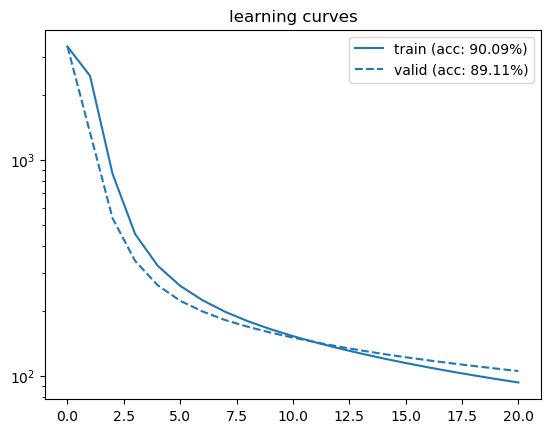

In [237]:
plot_curves(net, train_err, valid_err);

### Exercise 6: Training a Multi-layer Network (3 Points)

It would have been silly to do all of this work to train logistic regression.
Something you probably already would have been able to do before the start of this course.
The real goal is to train *deep* networks with multiple layers.
You probably can't wait to build a convolutional network with your framework!

> Use one of the optimisers from above to train a multi-layer convolutional neural network on the MNIST dataset. 
> Feel free to also create new modules and try out new things! (make sure to include any new code in the notebook!).
> Achieve a model with 80% accuracy to collect all points. 
> For reference: the sample solution (using the LeNet architecture illustrated below) takes &approx;15&nbsp;min to train for 10&nbsp;epochs.

**Hint:** You can probably reuse a few things from the previous exercise.

<figure>
    <figcaption style="width: 100%; text-align: center;">LeNet-5 architecture</figcaption>
    <img src="https://miro.medium.com/max/2154/1*1TI1aGBZ4dybR6__DI9dzA.png" />
</figure>

In [238]:
class ScaledTanh(Tanh):
    
    def __init__(self, bound=1.7159, slope=2. / 3.):
        super().__init__()
        self.bound = bound
        self.slope = slope
    
    def compute_outputs(self, x):
        a, cache = super().compute_outputs(self.slope * x)
        return self.bound * a, cache
    
    def compute_grads(self, grads, cache):
        return self.slope * super().compute_grads(self.bound * grads, cache)

In [ ]:
# cnn = ...
# train_err, valid_err = train(...)
# YOUR CODE HERE
raise NotImplementedError()

In [241]:
#epochs=10

# cnn = ...
# train_err, valid_err = train(...)
# YOUR CODE HERE
#raise NotImplementedError()

train_data, valid_data = split_data(x_train, y_train, ratio=0.8)
train_loader = Dataloader(*train_data, batch_size=128)
valid_loader = Dataloader(*valid_data, batch_size=128)

cnn = Sequential(
    Conv2d(1,6,(5,5)),
    ScaledTanh(),
    MaxPool2d((2,2)),
    Conv2d(6,16,(5,5)),
    ScaledTanh(),
    MaxPool2d((2,2)),
    Flatten(),
    Linear(16*5*5, 120),
    Linear(120, 84),
    Linear(84,10 )

)

optimizer = Adamax(cnn.parameters(), lr=0.01)

losses = LogitCrossEntropy(reduction='none')

train_err, valid_err = train(train_loader, valid_loader, cnn, losses, optimizer, epochs=10)

Evaluating 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:06<00:00, 14.24it/s]


Evaluating 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.71s/it]


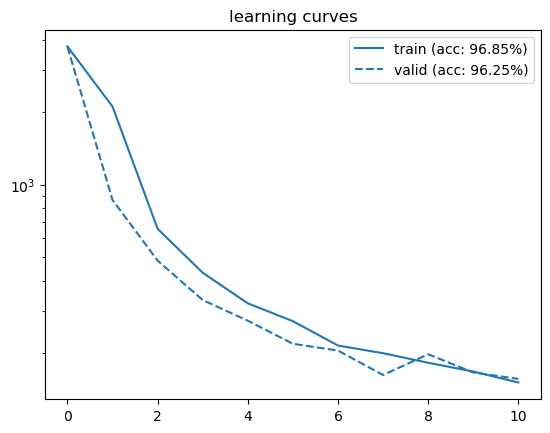

In [242]:
plot_curves(cnn, train_err, valid_err);

In [239]:
#epochs=20

# cnn = ...
# train_err, valid_err = train(...)
# YOUR CODE HERE
#raise NotImplementedError()

train_data, valid_data = split_data(x_train, y_train, ratio=0.8)
train_loader = Dataloader(*train_data, batch_size=128)
valid_loader = Dataloader(*valid_data, batch_size=128)

cnn = Sequential(
    Conv2d(1,6,(5,5)),
    ScaledTanh(),
    MaxPool2d((2,2)),
    Conv2d(6,16,(5,5)),
    Tanh(),
    MaxPool2d((2,2)),
    Flatten(),
    Linear(16*5*5, 120),
    Linear(120, 84),
    Linear(84,10 )

)

optimizer = Adamax(cnn.parameters(), lr=0.01)

losses = LogitCrossEntropy(reduction='none')

train_err, valid_err = train(train_loader, valid_loader, cnn, losses, optimizer, epochs=20)

Evaluating 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:07<00:00, 13.42it/s]


Evaluating 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.26s/it]


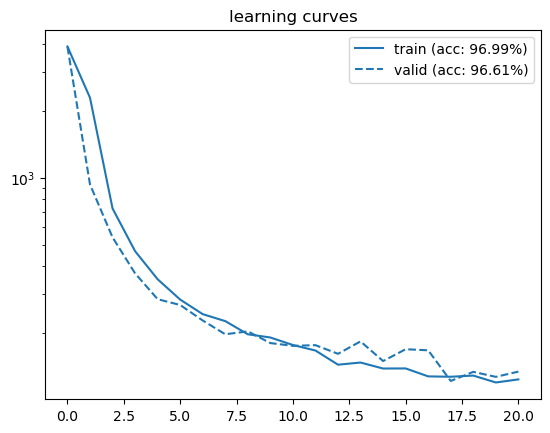

In [240]:
plot_curves(cnn, train_err, valid_err);

Is this what you expected?

Yes, It's expected . When building  CNN with multiple layers ,the accuracy increases ( training , validation ).
I used 10 epochs at the first time and used 20 epochs at the second time to compare the results . The results nearly the same , so we don't have to  increase the no of epochs .



In [ ]:
# Test Cell: do not edit or delete!